# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-25

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math, sys

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [2]:
# Importing dependencies
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
sys.path.append(r"..")
import microspot_util as msu
import microspot_util.plots as plots
%matplotlib widget


## User Input

In [3]:
inputfile=Path(r"../test_images/standard_mix.tif")
outputfolder=Path(r"../output")

first_spot="A1"
last_spot="L20"

ctrl_rows=["E"]
ctrl_cols=[]

### Extracting Information from User Input

In [4]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

2023-11-29 10:41:47.035 
  command:

    streamlit run /home/nesiron/anaconda3/envs/test_petras/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-11-29 10:41:47.037 No runtime found, using MemoryCacheStorageManager


## Loading the Image File

2023-11-29 10:41:50.475 No runtime found, using MemoryCacheStorageManager


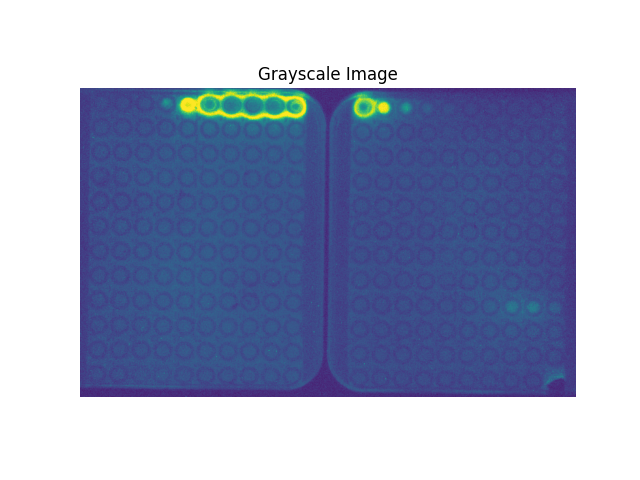

In [5]:
# Load and prepare raw image file.
raw_img=msu.prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image");

## Inital Spot and Grid detection

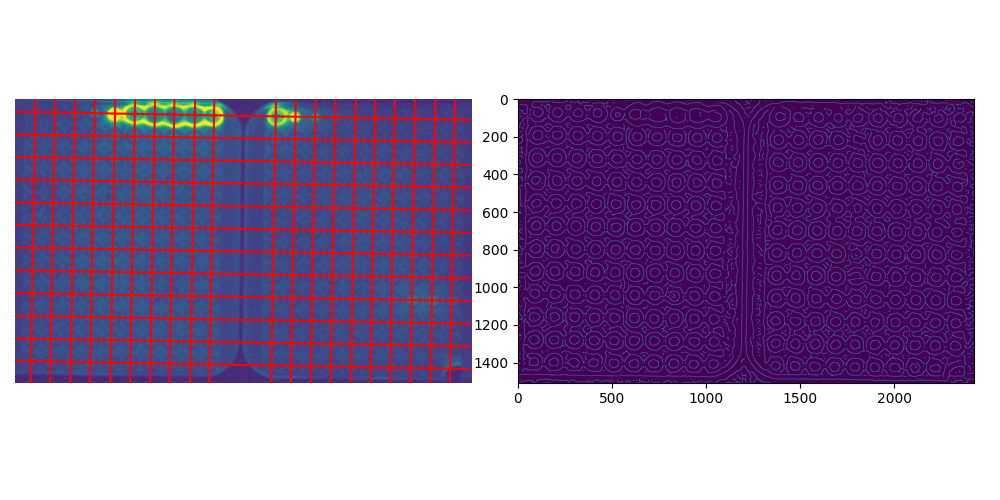

In [11]:
# Inital spot-detection.
init_spots,test=msu.spot.detect(
    gray_img=raw_img,
    spot_nr=grid_props["spot_nr"],
    canny_sig=10,
    canny_lowthresh=0.001,
    canny_highthresh=0.001,
    hough_minx=70,
    hough_miny=70,
    hough_thresh=0.3,
    small_rad=20,
    large_rad=30,
    troubleshoot=True
    )

avg_spotradius=np.mean([s.rad for s in init_spots])

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=msu.gridline.detect(
    img=dot_img,
    max_tilt=5,
    min_dist=80,
    threshold=0.2
    )

hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots(1,2,figsize=(10,5))
plots.plot_grid(fig,ax[0],raw_img,hor_line+vert_line)
ax[1].imshow(test["edge"])

## Spot Correction, Sorting and Intensity Determination

In [12]:
# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=10:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot. The spots are backfilled with the average radius for spots during initial detection
for g_point in grid_points:
    if g_point.min_dist>10:
        msu.spot.backfill(corr_spots,g_point.x,g_point.y,avg_spotradius)

sort_spots=msu.spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])

for s in sort_spots:
    s.get_intensity(raw_img)

    if s.row_name in ctrl_rows or s.col in ctrl_cols:
        s.type="Control"

## Halo Detection

In [13]:
# Detect Halos using the halo.detect method.
halos=msu.halo.detect(
    img=raw_img,
    min_rad=40,
    max_rad=100,
    min_xdist=70,
    min_ydist=70,
    thresh=0.2,
    min_obj_size=800
    )

# Assign halos to their spot.
for s in sort_spots:
    s.assign_halo(halos)


2023-11-29 10:46:14.754 No runtime found, using MemoryCacheStorageManager


## Normalization using Controls

In [14]:
# If controls are present, normalize the spot intensities 
if len(ctrl_rows) != 0 or len(ctrl_cols) != 0:
    msu.spot.normalize(sort_spots)

## Scaling of Halo

In [ ]:
# Scale to raw spot intensities (Not recommended!!)
for s in sort_spots:
    if s.halo > 0:
        s.int=s.halo/30

In [21]:
# Scale to normalized spot intensities (Recommended!!)
for s in sort_spots:
    if s.halo > 0:
        s.norm_int=s.halo/25

,row,row_name,column,type,x_coord,y_coord,radius,halo,spot_intensity,norm_intensity,note,RT
0,1,A,1,Sample,106,69,25,NaN,0.713319,0.985610,Initial Detection,NaN
1,1,A,2,Sample,210,70,26,NaN,0.713298,0.985580,Initial Detection,NaN
2,1,A,3,Sample,322,74,20,NaN,0.721128,0.996398,Initial Detection,NaN
3,1,A,4,Sample,421,73,23,NaN,0.788749,1.089832,Initial Detection,NaN
4,1,A,5,Sample,531,77,23,NaN,0.993517,1.372765,Backfilled,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
235,12,L,16,Sample,1894,1423,25,NaN,0.715067,0.988024,Initial Detection,NaN
236,12,L,17,Sample,1991,1426,21,NaN,0.714900,0.987794,Initial Detection,NaN
237,12,L,18,Sample,2106,1427,25,NaN,0.713441,0.985777,Initial Detection,NaN
238,12,L,19,Sample,2218,1430,21,NaN,0.707942,0.978180,Initial Detection,NaN


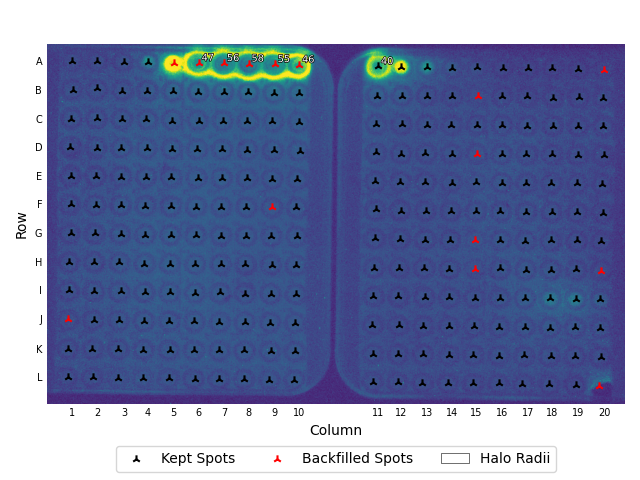

In [22]:
# Display the corrected and sorted spotlist.
sort_spot=msu.spot.create_df(sort_spots)

fig,ax=plt.subplots()
plots.plot_result(fig,ax,raw_img,sort_spot,grid_props)

sort_spot


## Heatmap

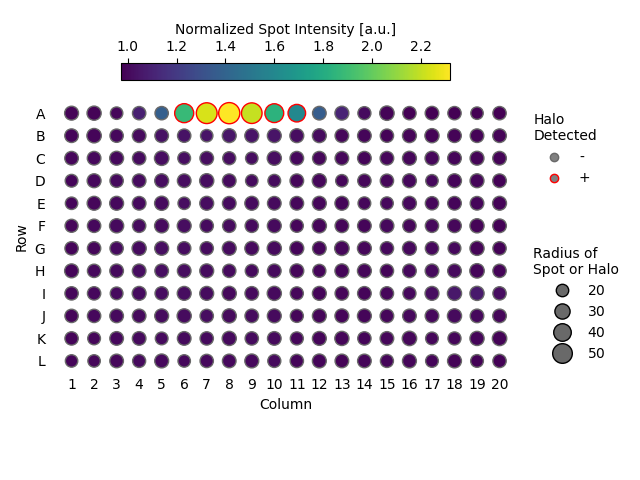

In [26]:
fig,ax=plt.subplots()
plots.plot_heatmapv2(fig,ax,sort_spot,row_conv_inv,norm_data=True,halo=True)

## Save Results

In [25]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spot.to_csv(outputfile)